In [6]:
#!conda install -y linearmodels
#%pip install statsmodels

In [7]:
import pandas as pd
import numpy as np
import math
from statsmodels.api import OLS, add_constant
import pandas_datareader.data as web

from linearmodels.asset_pricing import LinearFactorModel

import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
sns.set_style('whitegrid')

In [9]:
ff_factor = 'F-F_Research_Data_5_Factors_2x3'
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2010', end='2024-08')[0]
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 175 entries, 2010-01 to 2024-07
Freq: M
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  175 non-null    float64
 1   SMB     175 non-null    float64
 2   HML     175 non-null    float64
 3   RMW     175 non-null    float64
 4   CMA     175 non-null    float64
 5   RF      175 non-null    float64
dtypes: float64(6)
memory usage: 9.6 KB


/var/folders/5f/5s78cfys7rxc39jwjz0314g80000gn/T/ipykernel_76650/1192430917.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2010', end='2024-08')[0]
/var/folders/5f/5s78cfys7rxc39jwjz0314g80000gn/T/ipykernel_76650/1192430917.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2010', end='2024-08')[0]


In [10]:
ff_factor_data

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2010-01,-3.36,0.34,0.43,-1.27,0.46,0.00
2010-02,3.40,1.51,3.22,-0.27,1.42,0.00
2010-03,6.31,1.85,2.21,-0.65,1.69,0.01
2010-04,2.00,4.98,2.89,0.69,1.72,0.01
2010-05,-7.89,0.05,-2.44,1.30,-0.22,0.01
...,...,...,...,...,...,...
2024-03,2.83,-1.18,4.21,1.47,1.19,0.43
2024-04,-4.67,-2.56,-0.52,1.48,-0.30,0.47
2024-05,4.34,0.76,-1.66,2.98,-3.07,0.44


In [11]:
ff_factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000
mean,1.078457,-0.043486,-0.107486,0.300686,0.033257,0.085486
std,4.399326,2.740137,3.308995,1.964608,2.105274,0.134893
min,-13.390000,-8.240000,-13.880000,-4.790000,-7.200000,0.000000
25%,-1.540000,-1.910000,-1.890000,-1.110000,-1.335000,0.000000
50%,1.360000,0.040000,-0.410000,0.300000,-0.060000,0.010000
75%,3.530000,1.540000,1.430000,1.440000,1.270000,0.135000
max,13.650000,8.330000,12.800000,7.270000,7.740000,0.470000


In [12]:
#%pip install refinitiv-dataplatform


In [13]:
import refinitiv.dataplatform as rdp
import pandas
%run ../credentials.ipynb

In [14]:
session = rdp.open_platform_session(
    APP_KEY,
    rdp.GrantPassword(
        username = RDP_LOGIN,
        password = RDP_PASSWORD
    )
)

In [15]:
dji = rdp.get_data('0#.DJI', fields=['TR.CommonName', 'TR.PriceClose',
                                      'TR.Volume', 'TR.TotalReturnYTD'])

In [16]:
dji

,instrument,TR.CommonName,TR.PriceClose,TR.Volume,YTD Total Return
0,GS.N,Goldman Sachs Group Inc,497.41,369437,31.6719468792594
1,NKE.N,Nike Inc,86.2,4815336,-19.3412540015433
2,CSCO.OQ,Cisco Systems Inc,52.19,4749533,5.41135494661293
3,JPM.N,JPMorgan Chase & Co,211.44,2515809,26.2969251866126
4,DIS.N,Walt Disney Co,92.97,1742598,4.31196146387696
5,INTC.OQ,Intel Corp,22.56,46982239,-55.946180139607
6,DOW.N,Dow Inc,52.04,1902341,-2.08704036329441
7,MRK.N,Merck & Co Inc,115.63,2420307,9.52593465063596
8,CVX.N,Chevron Corp,147.54,2149767,0.803037681301677
9,AXP.N,American Express Co,267.3,881708,44.9326734528519


In [17]:
const = dji['instrument'].tolist()
const_limp = [i for i in const if i != '']
const = const_limp

In [18]:
from datetime import datetime, timedelta
end = datetime.today() - timedelta(days=(30*2))
start = end - timedelta(days=(365.2*14.6))
print(start, end)

2009-12-19 18:10:29.413516 2024-07-25 16:15:17.413516


In [19]:
df1 = rdp.get_historical_price_summaries(
    universe = const[0],
    interval = rdp.Intervals.MONTHLY,          # Supported intervals: DAILY, WEEKLY, MONTHLY, QUARTERLY, YEARLY.
    start=start, end=end,
    fields = ['BID']
)
df1['BID'] = df1['BID'].astype(float)
df1[const[0]] = np.log(df1['BID'].div(df1['BID'].shift(1)))
monthly_returns = df1.drop(['BID'], axis=1)
monthly_returns 

list_instrument = const[1:]

for intrument in range(1,len(list_instrument)):
    print(list_instrument[intrument])
    df1 = rdp.get_historical_price_summaries(
    universe = list_instrument[intrument],
    interval = rdp.Intervals.MONTHLY,          # Supported intervals: DAILY, WEEKLY, MONTHLY, QUARTERLY, YEARLY.
    start=start, end=end,
    fields = ['BID']
    )
    df1['BID'] = df1['BID'].astype(float)
    df1[list_instrument[intrument]] = np.log(df1['BID'].div(df1['BID'].shift(1)))
    df1 = df1.drop(['BID'], axis=1)
    monthly_returns = monthly_returns.join(df1)

CSCO.OQ
JPM.N
DIS.N
INTC.OQ
DOW.N
MRK.N
CVX.N
AXP.N
VZ.N
HD.N
MCD.N
UNH.N
AMZN.OQ
KO.N
JNJ.N
MSFT.OQ
HON.OQ
CRM.N
PG.N
IBM.N
MMM.N
AAPL.OQ
WMT.N
CAT.N
AMGN.OQ
V.N
TRV.N
BA.N


In [20]:
monthly_returns

,GS.N,CSCO.OQ,JPM.N,DIS.N,INTC.OQ,DOW.N,MRK.N,CVX.N,AXP.N,VZ.N,...,PG.N,IBM.N,MMM.N,AAPL.OQ,WMT.N,CAT.N,AMGN.OQ,V.N,TRV.N,BA.N
2009-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-31,-0.125412,-0.063370,-0.068530,-0.087773,-0.051293,NaN,0.044476,-0.066481,-0.072722,-0.119785,...,0.014742,-0.067422,-0.027248,-0.093096,-0.000374,-0.087219,0.033206,-0.064096,0.016118,0.112655
2010-02-28,0.050099,0.079529,0.075465,0.055954,0.057646,NaN,-0.034118,0.002912,0.014241,-0.015775,...,0.028532,0.038969,-0.002866,0.063815,0.011726,0.087394,-0.032499,0.039864,0.035296,0.042367
2010-03-31,0.086697,0.067540,0.064151,0.111074,0.080904,NaN,0.011860,0.048777,0.076835,0.069753,...,-0.000316,0.008535,0.041909,0.138005,0.028459,0.097541,0.054151,0.066070,0.027255,0.138880
2010-04-30,-0.162612,0.034362,-0.050658,0.052725,0.025284,NaN,-0.063325,0.071373,0.110753,-0.071137,...,-0.018346,0.004745,0.058221,0.105361,-0.035888,0.078916,-0.041512,-0.008938,-0.060972,-0.003174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,0.072258,0.032396,0.074938,0.092690,0.026160,0.036214,0.036988,0.037801,0.037729,0.047849,...,0.021379,0.032584,0.141825,-0.052596,0.026273,0.093371,0.037969,-0.013364,0.041445,-0.053324
2024-04-30,0.021112,-0.059898,-0.043733,-0.096643,-0.372164,-0.017943,-0.021610,0.022447,0.027295,-0.060431,...,0.006332,-0.138678,0.084858,-0.008610,-0.014230,-0.090497,-0.036946,-0.036871,-0.081282,-0.138523
2024-05-31,0.068042,-0.010055,0.057222,-0.066154,0.014680,0.012750,-0.027408,0.006920,0.025445,0.042876,...,0.008482,0.004084,0.036826,0.124142,0.103082,0.013006,0.109797,0.014633,0.016181,0.057023
2024-06-30,-0.009884,0.020641,-0.003059,-0.047070,0.001941,-0.082635,-0.014920,-0.037518,-0.035410,0.000970,...,0.001882,0.036252,0.020660,0.088737,0.029227,-0.017080,0.021711,-0.038479,-0.058950,0.024128


In [21]:
df2=monthly_returns.reset_index()
df2['Date'] = pd.to_datetime(df2['index']).dt.to_period('M')
returns = df2.set_index('Date').drop(['index'], axis=1)
returns

,GS.N,CSCO.OQ,JPM.N,DIS.N,INTC.OQ,DOW.N,MRK.N,CVX.N,AXP.N,VZ.N,...,PG.N,IBM.N,MMM.N,AAPL.OQ,WMT.N,CAT.N,AMGN.OQ,V.N,TRV.N,BA.N
Date,,,,,,,,,,,,,,,,,,,,,
2009-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01,-0.125412,-0.063370,-0.068530,-0.087773,-0.051293,NaN,0.044476,-0.066481,-0.072722,-0.119785,...,0.014742,-0.067422,-0.027248,-0.093096,-0.000374,-0.087219,0.033206,-0.064096,0.016118,0.112655
2010-02,0.050099,0.079529,0.075465,0.055954,0.057646,NaN,-0.034118,0.002912,0.014241,-0.015775,...,0.028532,0.038969,-0.002866,0.063815,0.011726,0.087394,-0.032499,0.039864,0.035296,0.042367
2010-03,0.086697,0.067540,0.064151,0.111074,0.080904,NaN,0.011860,0.048777,0.076835,0.069753,...,-0.000316,0.008535,0.041909,0.138005,0.028459,0.097541,0.054151,0.066070,0.027255,0.138880
2010-04,-0.162612,0.034362,-0.050658,0.052725,0.025284,NaN,-0.063325,0.071373,0.110753,-0.071137,...,-0.018346,0.004745,0.058221,0.105361,-0.035888,0.078916,-0.041512,-0.008938,-0.060972,-0.003174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03,0.072258,0.032396,0.074938,0.092690,0.026160,0.036214,0.036988,0.037801,0.037729,0.047849,...,0.021379,0.032584,0.141825,-0.052596,0.026273,0.093371,0.037969,-0.013364,0.041445,-0.053324
2024-04,0.021112,-0.059898,-0.043733,-0.096643,-0.372164,-0.017943,-0.021610,0.022447,0.027295,-0.060431,...,0.006332,-0.138678,0.084858,-0.008610,-0.014230,-0.090497,-0.036946,-0.036871,-0.081282,-0.138523
2024-05,0.068042,-0.010055,0.057222,-0.066154,0.014680,0.012750,-0.027408,0.006920,0.025445,0.042876,...,0.008482,0.004084,0.036826,0.124142,0.103082,0.013006,0.109797,0.014633,0.016181,0.057023


In [22]:
excess_returns = returns.sub(ff_factor_data.RF, axis=0).drop(['DOW.N'], axis = 1)
excess_returns = excess_returns.dropna()
excess_returns

,GS.N,CSCO.OQ,JPM.N,DIS.N,INTC.OQ,MRK.N,CVX.N,AXP.N,VZ.N,HD.N,...,PG.N,IBM.N,MMM.N,AAPL.OQ,WMT.N,CAT.N,AMGN.OQ,V.N,TRV.N,BA.N
Date,,,,,,,,,,,,,,,,,,,,,
2010-01,-0.125412,-0.063370,-0.068530,-0.087773,-0.051293,0.044476,-0.066481,-0.072722,-0.119785,-0.031637,...,0.014742,-0.067422,-0.027248,-0.093096,-0.000374,-0.087219,0.033206,-0.064096,0.016118,0.112655
2010-02,0.050099,0.079529,0.075465,0.055954,0.057646,-0.034118,0.002912,0.014241,-0.015775,0.107572,...,0.028532,0.038969,-0.002866,0.063815,0.011726,0.087394,-0.032499,0.039864,0.035296,0.042367
2010-03,0.076697,0.057540,0.054151,0.101074,0.070904,0.001860,0.038777,0.066835,0.059753,0.026837,...,-0.010316,-0.001465,0.031909,0.128005,0.018459,0.087541,0.044151,0.056070,0.017255,0.128880
2010-04,-0.172612,0.024362,-0.060658,0.042725,0.015284,-0.073325,0.061373,0.100753,-0.081137,0.075568,...,-0.028346,-0.005255,0.048221,0.095361,-0.045888,0.068916,-0.051512,-0.018938,-0.070972,-0.013174
2010-05,-0.014634,-0.162482,-0.083150,-0.106942,-0.073750,-0.049301,-0.109321,-0.155291,-0.059309,-0.050243,...,-0.027378,-0.039773,-0.121677,-0.024822,-0.069134,-0.122905,-0.111820,-0.229631,-0.036157,-0.129841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03,-0.357742,-0.397604,-0.355062,-0.337310,-0.403840,-0.393012,-0.392199,-0.392271,-0.382151,-0.421407,...,-0.408621,-0.397416,-0.288175,-0.482596,-0.403727,-0.336629,-0.392031,-0.443364,-0.388555,-0.483324
2024-04,-0.448888,-0.529898,-0.513733,-0.566643,-0.842164,-0.491610,-0.447553,-0.442705,-0.530431,-0.607620,...,-0.463668,-0.608678,-0.385142,-0.478610,-0.484230,-0.560497,-0.506946,-0.506871,-0.551282,-0.608523
2024-05,-0.371958,-0.450055,-0.382778,-0.506154,-0.425320,-0.467408,-0.433080,-0.414555,-0.397124,-0.437280,...,-0.431518,-0.435916,-0.403174,-0.315858,-0.336918,-0.426994,-0.330203,-0.425367,-0.423819,-0.382977


In [23]:
excess_returns = excess_returns.clip(lower=np.percentile(excess_returns, 1),
                                     upper=np.percentile(excess_returns, 99))

# excess_returns

In [25]:
const = dji['instrument'].tolist()
const_limp = [i for i in const if i != '']
const_limp

['GS.N',
 'NKE.N',
 'CSCO.OQ',
 'JPM.N',
 'DIS.N',
 'INTC.OQ',
 'DOW.N',
 'MRK.N',
 'CVX.N',
 'AXP.N',
 'VZ.N',
 'HD.N',
 'MCD.N',
 'UNH.N',
 'AMZN.OQ',
 'KO.N',
 'JNJ.N',
 'MSFT.OQ',
 'HON.OQ',
 'CRM.N',
 'PG.N',
 'IBM.N',
 'MMM.N',
 'AAPL.OQ',
 'WMT.N',
 'CAT.N',
 'AMGN.OQ',
 'V.N',
 'TRV.N',
 'BA.N']

In [26]:
betas = []
for i in excess_returns.columns:
    step1 = OLS(endog=excess_returns.loc[:,i].astype(float), 
                exog=add_constant(ff_factor_data)).fit()
    betas.append(step1.params.drop('const'))
betas

[Mkt-RF    0.012604
 SMB      -0.000961
 HML       0.010292
 RMW      -0.004127
 CMA      -0.006888
 RF       -0.963898
 dtype: float64,
 Mkt-RF    0.010168
 SMB      -0.002241
 HML       0.000429
 RMW       0.001509
 CMA      -0.000640
 RF       -0.998519
 dtype: float64,
 Mkt-RF    0.011326
 SMB      -0.002468
 HML       0.012228
 RMW      -0.007451
 CMA      -0.005793
 RF       -0.949805
 dtype: float64,
 Mkt-RF    0.012052
 SMB      -0.002716
 HML       0.002665
 RMW      -0.004997
 CMA      -0.001675
 RF       -1.021551
 dtype: float64,
 Mkt-RF    0.009435
 SMB      -0.001432
 HML      -0.000318
 RMW      -0.001058
 CMA       0.002849
 RF       -0.947121
 dtype: float64,
 Mkt-RF    0.005495
 SMB      -0.004833
 HML      -0.003419
 RMW      -0.002441
 CMA       0.010813
 RF       -0.976071
 dtype: float64,
 Mkt-RF    0.009896
 SMB      -0.000563
 HML       0.006488
 RMW       0.000106
 CMA       0.006464
 RF       -0.991563
 dtype: float64,
 Mkt-RF    0.010187
 SMB       0.000713
 

In [27]:
betas = pd.DataFrame(betas, 
                     columns=ff_factor_data.columns, 
                     index=excess_returns.columns)
betas

,Mkt-RF,SMB,HML,RMW,CMA,RF
GS.N,0.012604,-0.000961,0.010292,-0.004127,-0.006888,-0.963898
CSCO.OQ,0.010168,-0.002241,0.000429,0.001509,-0.000640,-0.998519
JPM.N,0.011326,-0.002468,0.012228,-0.007451,-0.005793,-0.949805
DIS.N,0.012052,-0.002716,0.002665,-0.004997,-0.001675,-1.021551
INTC.OQ,0.009435,-0.001432,-0.000318,-0.001058,0.002849,-0.947121
MRK.N,0.005495,-0.004833,-0.003419,-0.002441,0.010813,-0.976071
CVX.N,0.009896,-0.000563,0.006488,0.000106,0.006464,-0.991563
AXP.N,0.010187,0.000713,0.006337,-0.002030,-0.003921,-0.960890
VZ.N,0.005337,-0.004380,-0.001741,0.002383,0.008260,-0.986829
HD.N,0.009585,0.001103,-0.000127,0.004141,0.002065,-1.001467


In [28]:
excess_returns.index

PeriodIndex(['2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06',
             '2010-07', '2010-08', '2010-09', '2010-10',
             ...
             '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03',
             '2024-04', '2024-05', '2024-06', '2024-07'],
            dtype='period[M]', name='Date', length=175)

In [29]:
for period in betas.index:
    print(period)

GS.N
CSCO.OQ
JPM.N
DIS.N
INTC.OQ
MRK.N
CVX.N
AXP.N
VZ.N
HD.N
MCD.N
UNH.N
AMZN.OQ
KO.N
JNJ.N
MSFT.OQ
HON.OQ
CRM.N
PG.N
IBM.N
MMM.N
AAPL.OQ
WMT.N
CAT.N
AMGN.OQ
V.N
TRV.N
BA.N


In [31]:
for period in excess_returns.index:
    print(period)

2010-01
2010-02
2010-03
2010-04
2010-05
2010-06
2010-07
2010-08
2010-09
2010-10
2010-11
2010-12
2011-01
2011-02
2011-03
2011-04
2011-05
2011-06
2011-07
2011-08
2011-09
2011-10
2011-11
2011-12
2012-01
2012-02
2012-03
2012-04
2012-05
2012-06
2012-07
2012-08
2012-09
2012-10
2012-11
2012-12
2013-01
2013-02
2013-03
2013-04
2013-05
2013-06
2013-07
2013-08
2013-09
2013-10
2013-11
2013-12
2014-01
2014-02
2014-03
2014-04
2014-05
2014-06
2014-07
2014-08
2014-09
2014-10
2014-11
2014-12
2015-01
2015-02
2015-03
2015-04
2015-05
2015-06
2015-07
2015-08
2015-09
2015-10
2015-11
2015-12
2016-01
2016-02
2016-03
2016-04
2016-05
2016-06
2016-07
2016-08
2016-09
2016-10
2016-11
2016-12
2017-01
2017-02
2017-03
2017-04
2017-05
2017-06
2017-07
2017-08
2017-09
2017-10
2017-11
2017-12
2018-01
2018-02
2018-03
2018-04
2018-05
2018-06
2018-07
2018-08
2018-09
2018-10
2018-11
2018-12
2019-01
2019-02
2019-03
2019-04
2019-05
2019-06
2019-07
2019-08
2019-09
2019-10
2019-11
2019-12
2020-01
2020-02
2020-03
2020-04
2020-05


In [32]:
betas.index

Index(['GS.N', 'CSCO.OQ', 'JPM.N', 'DIS.N', 'INTC.OQ', 'MRK.N', 'CVX.N',
       'AXP.N', 'VZ.N', 'HD.N', 'MCD.N', 'UNH.N', 'AMZN.OQ', 'KO.N', 'JNJ.N',
       'MSFT.OQ', 'HON.OQ', 'CRM.N', 'PG.N', 'IBM.N', 'MMM.N', 'AAPL.OQ',
       'WMT.N', 'CAT.N', 'AMGN.OQ', 'V.N', 'TRV.N', 'BA.N'],
      dtype='object')

In [33]:
excess_returns.loc['2010-10', betas.index]

GS.N       0.097821
CSCO.OQ    0.031151
JPM.N     -0.020837
DIS.N      0.077037
INTC.OQ    0.030301
MRK.N     -0.024231
CVX.N      0.008459
AXP.N     -0.023429
VZ.N      -0.013997
HD.N      -0.035577
MCD.N      0.032834
UNH.N      0.015311
AMZN.OQ    0.040293
KO.N       0.036737
JNJ.N      0.017709
MSFT.OQ    0.074966
HON.OQ     0.059660
CRM.N      0.027396
PG.N       0.048473
IBM.N      0.057948
MMM.N     -0.039137
AAPL.OQ    0.048690
WMT.N      0.001887
CAT.N     -0.011526
AMGN.OQ    0.027048
V.N        0.042412
TRV.N      0.046892
BA.N       0.050395
Name: 2010-10, dtype: float64

In [34]:
betas

,Mkt-RF,SMB,HML,RMW,CMA,RF
GS.N,0.012604,-0.000961,0.010292,-0.004127,-0.006888,-0.963898
CSCO.OQ,0.010168,-0.002241,0.000429,0.001509,-0.000640,-0.998519
JPM.N,0.011326,-0.002468,0.012228,-0.007451,-0.005793,-0.949805
DIS.N,0.012052,-0.002716,0.002665,-0.004997,-0.001675,-1.021551
INTC.OQ,0.009435,-0.001432,-0.000318,-0.001058,0.002849,-0.947121
MRK.N,0.005495,-0.004833,-0.003419,-0.002441,0.010813,-0.976071
CVX.N,0.009896,-0.000563,0.006488,0.000106,0.006464,-0.991563
AXP.N,0.010187,0.000713,0.006337,-0.002030,-0.003921,-0.960890
VZ.N,0.005337,-0.004380,-0.001741,0.002383,0.008260,-0.986829
HD.N,0.009585,0.001103,-0.000127,0.004141,0.002065,-1.001467


In [35]:
lambdas = []
for period in excess_returns.index:
    step2 = OLS(endog=excess_returns.loc[period, betas.index].astype(float), 
                exog=betas).fit()
    lambdas.append(step2.params)

In [36]:
lambdas

[Mkt-RF   -12.471883
 SMB        9.090705
 HML       -1.084411
 RMW       -1.438678
 CMA        1.516178
 RF        -0.087501
 dtype: float64,
 Mkt-RF    5.639650
 SMB       2.857057
 HML       1.967681
 RMW       2.243761
 CMA      -1.030812
 RF        0.019801
 dtype: float64,
 Mkt-RF    15.445095
 SMB        0.029845
 HML       -3.214420
 RMW        0.598573
 CMA       -0.203350
 RF         0.084254
 dtype: float64,
 Mkt-RF    13.175850
 SMB        4.717327
 HML       -5.956719
 RMW        4.136271
 CMA       -2.302341
 RF         0.105463
 dtype: float64,
 Mkt-RF   -13.582483
 SMB        4.871500
 HML       -0.225891
 RMW       -1.934920
 CMA       -3.176851
 RF        -0.047319
 dtype: float64,
 Mkt-RF   -13.008802
 SMB        5.859683
 HML       -0.491188
 RMW       -3.188774
 CMA        0.769865
 RF        -0.075596
 dtype: float64,
 Mkt-RF    4.742472
 SMB       0.974654
 HML       2.818712
 RMW      -0.601215
 CMA      -1.384183
 RF       -0.019211
 dtype: float64,
 Mkt-RF   -

In [38]:
lambdas = pd.DataFrame(lambdas, 
                       index=excess_returns.index,
                       columns=betas.columns.tolist())
lambdas

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2010-01,-12.471883,9.090705,-1.084411,-1.438678,1.516178,-0.087501
2010-02,5.639650,2.857057,1.967681,2.243761,-1.030812,0.019801
2010-03,15.445095,0.029845,-3.214420,0.598573,-0.203350,0.084254
2010-04,13.175850,4.717327,-5.956719,4.136271,-2.302341,0.105463
2010-05,-13.582483,4.871500,-0.225891,-1.934920,-3.176851,-0.047319
...,...,...,...,...,...,...
2024-03,3.160755,1.684168,2.236181,-3.159939,3.553072,0.437784
2024-04,-2.906587,1.413262,1.546331,3.373840,-1.645818,0.470015
2024-05,7.031740,-3.598676,-0.027936,6.590965,0.731600,0.497821


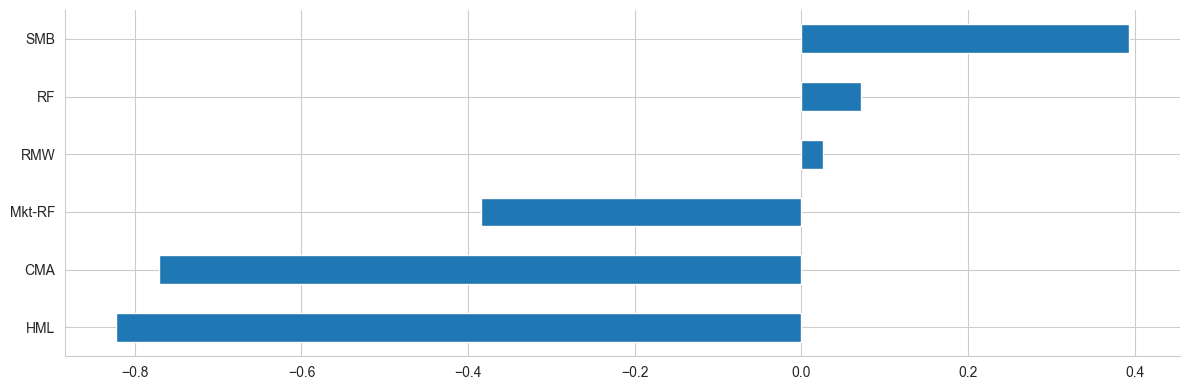

In [39]:
lambdas.mean().sort_values().plot.barh(figsize=(12, 4))
sns.despine()
plt.tight_layout();

In [40]:
t = lambdas.mean().div(lambdas.std())
t

Mkt-RF   -0.049686
SMB       0.073248
HML      -0.183227
RMW       0.006780
CMA      -0.225526
RF        0.479492
dtype: float64

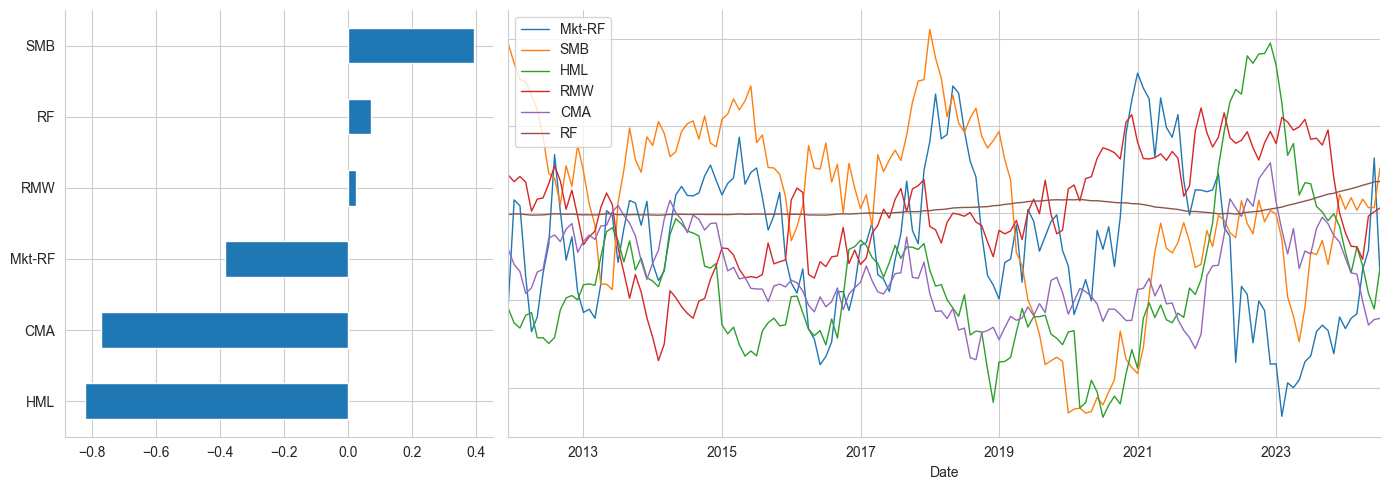

In [41]:
window = 24  # months
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
lambdas.mean().sort_values().plot.barh(ax=ax1)
lambdas.rolling(window).mean().dropna().plot(lw=1,
                                             figsize=(14, 5),
                                             sharey=True,
                                             ax=ax2)
sns.despine()
plt.tight_layout()

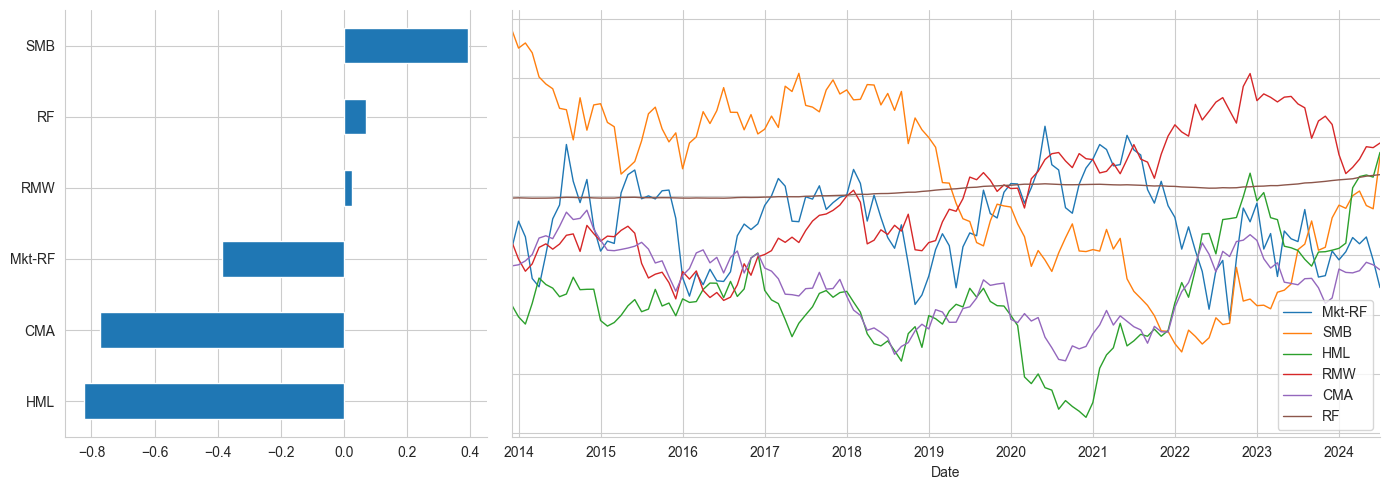

In [42]:
window = 48  # months
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
lambdas.mean().sort_values().plot.barh(ax=ax1)
lambdas.rolling(window).mean().dropna().plot(lw=1,
                                             figsize=(14, 5),
                                             sharey=True,
                                             ax=ax2)
sns.despine()
plt.tight_layout()

In [49]:
mod = LinearFactorModel(portfolios=excess_returns, 
                        factors=ff_factor_data)
res = mod.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 29   R-squared:                      0.8842
No. Factors:                          6   J-statistic:                    42.980
No. Observations:                   170   P-value                         0.0070
Date:                  Tue, Apr 23 2024   Distribution:                 chi2(23)
Time:                          17:14:43                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF        -0.5115     0.8891    -0.5753     0.5651     -2.2542      1.2312
SMB            0.3434     0.6456    

In [50]:
print(res.full_summary)


                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 29   R-squared:                      0.8842
No. Factors:                          6   J-statistic:                    42.980
No. Observations:                   170   P-value                         0.0070
Date:                  Tue, Apr 23 2024   Distribution:                 chi2(23)
Time:                          17:14:43                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF        -0.5115     0.8891    -0.5753     0.5651     -2.2542      1.2312
SMB            0.3434     0.6456    